## Configurations for Colab

In [111]:
import csv
import cv2
import gym
import h5py
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import operator
import pandas as pd
import random
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
from IPython.display import clear_output
from matplotlib.collections import PathCollection
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
from typing import Callable, Deque, Dict, List, Tuple

working_directory = './'

for filename in os.listdir(working_directory):
    file_path = os.path.join(working_directory, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')
        
class SegmentTree:

    def __init__(self, capacity: int, operation: Callable, init_value: float):

        assert (
            capacity > 0 and capacity & (capacity - 1) == 0
        ), "capacity must be positive and a power of 2."
        self.capacity = capacity
        self.tree = [init_value for _ in range(2 * capacity)]
        self.operation = operation

    def _operate_helper(
        self, start: int, end: int, node: int, node_start: int, node_end: int
    ) -> float:
        """Returns result of operation in segment."""
        if start == node_start and end == node_end:
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(
                    self._operate_helper(start, mid, 2 * node, node_start, mid),
                    self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end),
                )

    def operate(self, start: int = 0, end: int = 0) -> float:
        """Returns result of applying `self.operation`."""
        if end <= 0:
            end += self.capacity
        end -= 1

        return self._operate_helper(start, end, 1, 0, self.capacity - 1)

    def __setitem__(self, idx: int, val: float):
        """Set value in tree."""
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx: int) -> float:
        """Get real value in leaf node of tree."""
        assert 0 <= idx < self.capacity

        return self.tree[self.capacity + idx]


class SumSegmentTree(SegmentTree):

    def __init__(self, capacity: int):

        super(SumSegmentTree, self).__init__(
            capacity=capacity, operation=operator.add, init_value=0.0
        )

    def sum(self, start: int = 0, end: int = 0) -> float:
        """Returns arr[start] + ... + arr[end]."""
        return super(SumSegmentTree, self).operate(start, end)

    def retrieve(self, upperbound: float) -> int:
        """Find the highest index `i` about upper bound in the tree"""
        # TODO: Check assert case and fix bug
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)

        idx = 1

        while idx < self.capacity:  # while non-leaf
            left = 2 * idx
            right = left + 1
            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right
        return idx - self.capacity


class MinSegmentTree(SegmentTree):

    def __init__(self, capacity: int):

        super(MinSegmentTree, self).__init__(
            capacity=capacity, operation=min, init_value=float("inf")
        )

    def min(self, start: int = 0, end: int = 0) -> float:
        """Returns min(arr[start], ...,  arr[end])."""
        return super(MinSegmentTree, self).operate(start, end)

class CryptoTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, transaction_fee):
        super(CryptoTradingEnv, self).__init__()
        self.historical_data = pd.read_csv('/kaggle/input/gaf-price-btc-eth/price-btc-eth.csv', header=None).values
        self.transaction_fee = transaction_fee
        self.current_step = 0
        self.position = 0
        self.PnL = 0.0
        self.last_btc_price = 0
        self.last_eth_price = 0
        self.btc_price_current = 0
        self.eth_price_current = 0
        self.last_step = 0
        self.hedge_ratio = 0.0
        self.reward = 0.0
        # Define action space
        self.action_space = gym.spaces.Discrete(3)

        # Define observation space
        img_space = gym.spaces.Box(low=0, high=255, shape=(4, 10, 10), dtype=np.float32)
        position_space = gym.spaces.Discrete(3)
        #return_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.observation_space = gym.spaces.Tuple((img_space, position_space))
        
    def log_to_csv(self, is_test, epoch, current_step, prev_position, action, new_position, last_step, last_btc_price, last_eth_price, current_btc_price, current_eth_price, reward_PnL):
        with open('crypto_trading_log.csv', 'a', newline='') as csvfile:
            log_writer = csv.writer(csvfile)
            if not os.path.exists('crypto_trading_log.csv') or os.stat('crypto_trading_log.csv').st_size == 0:
                log_writer.writerow(['is_test', 'epoch', 'current_step', 'prev_position', 'action', 'new_position', 'last_step', 'last_btc_price', 'last_eth_price', 'current_btc_price', 'current_eth_price','reward_PnL'])
            log_writer.writerow([is_test, epoch, current_step, prev_position, action, new_position, last_step, last_btc_price, last_eth_price, current_btc_price, current_eth_price,reward_PnL])
    
    def calculate_eth_amount(self, btc_price, eth_price):
        return btc_price / eth_price  
    
    def step(self, action, epoch, is_test):

        self.current_step += 1

        if  self.position == 1: #Long BTC Short ETH
            self.btc_price_current = self.historical_data[self.current_step, 1] * (1-self.transaction_fee)
            self.eth_price_current = self.historical_data[self.current_step, 2] * (1+self.transaction_fee)
            self.PnL = ((self.btc_price_current - self.last_btc_price) ) + ((-self.eth_price_current + self.last_eth_price) * self.hedge_ratio )  

        elif self.position == 2: #Long ETH Short BTC
            self.btc_price_current = self.historical_data[self.current_step, 1] * (1+self.transaction_fee)
            self.eth_price_current = self.historical_data[self.current_step, 2] * (1-self.transaction_fee)
            self.PnL = ((-self.btc_price_current + self.last_btc_price) ) + ((self.eth_price_current - self.last_eth_price) * self.hedge_ratio)  
        
        elif self.position == 0: #No position
            self.btc_price_current = 0
            self.eth_price_current = 0
            self.PnL = 0
            
        position = self.position
        new_position = action

        
        if self.PnL > 100:
              self.reward = 100
        elif self.PnL < -100:
              self.reward = -100
        else:
            self.reward = self.PnL
            
        PnL = self.PnL
        
        self.log_to_csv(is_test,epoch, self.current_step, self.position, action, new_position, self.last_step, self.last_btc_price, self.last_eth_price, self.btc_price_current, self.eth_price_current, PnL)

        if new_position == 1: #Long BTC Short ETH
            self.last_btc_price = self.historical_data[self.current_step, 1] * (1+self.transaction_fee)
            self.last_eth_price = self.historical_data[self.current_step, 2] * (1-self.transaction_fee)
            self.hedge_ratio = self.historical_data[self.current_step, 1] / self.historical_data[self.current_step, 2]
            self.last_step = self.current_step
        elif new_position == 2: #Long ETH Short BTC
            self.last_btc_price = self.historical_data[self.current_step, 1] * (1-self.transaction_fee)
            self.last_eth_price = self.historical_data[self.current_step, 2] * (1+self.transaction_fee)
            self.hedge_ratio = self.historical_data[self.current_step, 1] / self.historical_data[self.current_step, 2]
            self.last_step = self.current_step
        elif new_position == 0: #No position
            self.last_btc_price = 0
            self.last_eth_price = 0
            self.hedge_ratio = 0
            self.last_step = self.current_step
                  
        
        
        self.position = new_position
        
        reward = self.reward
        done = self.current_step >= len(self.historical_data) - 1
        obs = self._get_observation()

        return obs, reward, done,PnL, position, {}

    def reset(self,start_frame: int=0):
        self.current_step = start_frame
        self.position = 0 
        self.PnL = 0.0
        self.last_btc_price = 0
        self.last_eth_price = 0
        self.last_step = 0
        self.hedge_ratio = 0.0
        self.reward = 0.0
        return self._get_observation()

    def render(self, mode='human', close=False):
        if mode == 'human':
            print(f"Step: {self.current_step}, Position: {self.position}, Return: {self.return_percent}%")

    def close(self):
        pass

    def _get_observation(self):
        img = self._get_image(self.current_step)
        obs = (img, self.position)
        return obs

    def _get_image(self, step):
        with h5py.File('/kaggle/input/gaf-price-btc-eth/gaf-btc-eth-spread-10bars.hdf5', 'r') as hdf5_file:
            img_data = hdf5_file[str(step)][()]
        return img_data

class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self, 
        obs_dims: Tuple[int, int, int], 
        size: int, 
        batch_size: int, 
        n_step: int = 100, 
        gamma: float = 0.9
    ):
        self.obs_buf = [np.zeros([size, *obs_dim], dtype=np.float32) for obs_dim in obs_dims]
        self.next_obs_buf = [np.zeros([size, *obs_dim], dtype=np.float32) for obs_dim in obs_dims]
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0
        
        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self, 
        obs: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        act: np.ndarray, 
        rew: float, 
        next_obs: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()
        
        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]
        
        for i in range(len(obs)):
            self.obs_buf[i][self.ptr] = obs[i]
            self.next_obs_buf[i][self.ptr] = next_obs[i]
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=[buf[idxs] for buf in self.obs_buf],
            next_obs=[buf[idxs] for buf in self.next_obs_buf],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )
    
    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=[buf[idxs] for buf in self.obs_buf],
            next_obs=[buf[idxs] for buf in self.next_obs_buf],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )
    
    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, Tuple[np.ndarray, np.ndarray, np.ndarray], bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

class PrioritizedReplayBuffer(ReplayBuffer):

    def __init__(
        self, 
        obs_dims: Tuple[int, int, int], 
        size: int, 
        batch_size: int, 
        alpha: float = 0.6,
        n_step: int = 100, 
        gamma: float = 0.95,
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(
            obs_dims, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
        
        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
        self, 
        obs: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        act: int, 
        rew: float, 
        next_obs: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)
        
        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size
        
        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0
        
        indices = self._sample_proportional()
        
        obs = [buf[indices] for buf in self.obs_buf]
        next_obs = [buf[indices] for buf in self.next_obs_buf]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])
        
        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)
            
    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size
        
        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
            
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

class NoisyLinear(nn.Module):

    def __init__(
        self, 
        in_features: int, 
        out_features: int, 
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

#Customized CNN For Trading Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CustomCNNWithFeatures(nn.Module):
    def __init__(self):
        super(CustomCNNWithFeatures, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.elu2 = nn.ELU()
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.elu3 = nn.ELU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.elu4 = nn.ELU()
        
        self.fc1_input_size = None
        self.fc1 = None
        self.relu = nn.ReLU()
        
    def _initialize_fc1(self, x):
        self.fc1_input_size = x.size(1) * x.size(2) * x.size(3)
        self.fc1 = nn.Linear(self.fc1_input_size, 128).to(device)
        
    def forward(self, gaf, trade_position):
        x1 = self.conv1(gaf)
        x1 = self.elu1(x1)
        x1 = self.conv2(x1)
        x1 = self.elu2(x1)
        x1 = self.conv3(x1)
        x1 = self.elu3(x1)
        x1 = self.conv4(x1)
        x1 = self.elu4(x1)
        x2 = trade_position
        
        if self.fc1 is None:
            self._initialize_fc1(x1)
        
        x1 = x1.view(-1, self.fc1_input_size)
        x1 = self.fc1(x1)
        x1 = self.relu(x1)
        
        x2 = x2 if isinstance(x2, torch.Tensor) else torch.tensor(x2).unsqueeze(0).to(device)
        x2 = torch.tensor(x2).unsqueeze(1).to(device)
     
        x = torch.cat((x1, x2), dim=1)
        
        return x
    
class Network(nn.Module):
    def __init__(
        self, 
        state_dim: int,
        out_dim: int, 
        atom_size: int, 
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # Set the customized ResNet50 model as the feature layer
        self.feature_layer = CustomCNNWithFeatures()

        # Get the output dimension of the custom cnn model
        cnn_out_dim = 129

        # Set advantage layer
        self.advantage_hidden_layer = NoisyLinear(cnn_out_dim, 128)
        self.advantage_layer = NoisyLinear(128, out_dim * atom_size)
        
        # Set value layer
        self.value_hidden_layer = NoisyLinear(cnn_out_dim, 128)
        self.value_layer = NoisyLinear(128, atom_size)
        

    def forward(self, x: torch.Tensor, trade_position: np.float32) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x, trade_position)
        q = torch.sum(dist * self.support, dim=2)
        
        return q
    
    def dist(self, x: torch.Tensor, trade_position: np.float32) -> torch.Tensor:
        """Get distribution for atoms."""
        feature = self.feature_layer(x, trade_position)
    
        adv_hid = F.relu(self.advantage_hidden_layer(feature))
        val_hid = F.relu(self.value_hidden_layer(feature))
        
        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans
        
        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()

class DQNAgent:

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        gamma: float = 0.95,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = -100.0,
        v_max: float = 100.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 100,
        lr : float = 0.00025,

    ):

        obs_dim = (env.observation_space[0].shape, env.observation_space[1].shape)
        action_dim = env.action_space.n
        self.epsilon= 0.99  # Initialize exploration rate
        self.epsilon_decay  = 0.9995  # Decay rate for exploration
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.gamma = gamma
        # NoisyNet: All attributes related to epsilon are removed
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha
        )
        
        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
            
        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target = Network(
            obs_dim, action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(), lr = lr)

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: Tuple[torch.Tensor, np.float32]) -> np.ndarray:
        """Select an action from the input state."""
        img, position = state
        
        self.Qvalues = self.dqn(
            torch.FloatTensor(img).unsqueeze(0).to(self.device),
            position
        )

        if not self.is_test and random.random() < self.epsilon:
            selected_action = random.randint(0, 2)
            is_random = 1
        else:
            if not self.is_test:
                Qvalues_softmax = F.softmax(F.normalize(self.Qvalues))
                selected_action = torch.multinomial(Qvalues_softmax,num_samples =1)
                selected_action = selected_action.item()
                is_random = 0
            else:
                selected_action = self.Qvalues.argmax()
                selected_action = selected_action.detach().cpu().numpy()
                is_random = 0

        if not self.is_test:
            self.transition = [state, selected_action]
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)  # Decay epsilon
            
        return selected_action, is_random

    def step(self, action: np.ndarray,epoch: int) -> Tuple[Tuple[np.ndarray, np.float32], np.float64]:
        """Take an action and return the response of the env."""
        next_state, reward, done, PnL, position, _ = self.env.step(action,epoch,self.is_test)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            
            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)
    
        return next_state, reward, done , PnL, position

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]
        
        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)
        
        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)
        
        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss
            
            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 3)
        self.optimizer.step()
        
        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)
        
        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()
 
    def train(self, num_frames: int, num_epochs: int, model_dir: str, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        losses = []
        
        for epoch in range(num_epochs):
            state = self.env.reset()
            update_cnt = 0
            
            list_PnL = []
            list_accumulated_PnL = []
           

            pbar = tqdm(range(1, num_frames + 1), desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)
            for frame_idx in pbar:
                
                action , is_random = self.select_action(state)
                next_state, reward, done, PnL, position= self.step(action,epoch)
                state = next_state
                

                # PER: increase beta
                fraction = min(frame_idx / num_frames, 1.0)
                self.beta = self.beta + fraction * (1.0 - self.beta)

                # if episode ends
                if done:
                    state = self.env.reset()
                    
                    
                list_PnL.append((PnL,position,is_random))
                if list_accumulated_PnL:
                    list_accumulated_PnL.append(list_accumulated_PnL[-1] + PnL)
                else:
                    list_accumulated_PnL.append(PnL)

                # if training is ready
                if len(self.memory) >= self.batch_size:
                    loss = self.update_model()
                    losses.append(loss)
                    update_cnt += 1

                    # Free up GPU memory
                    torch.cuda.empty_cache()

                    # if hard update is needed
                    if update_cnt % self.target_update == 0:
                        self._target_hard_update()

                # plotting
                if frame_idx % plotting_interval == 0:
                    self._plot(frame_idx, list_PnL, losses, list_accumulated_PnL)

            # Save the model after each epoch
            model_path = os.path.join(model_dir, f"model_epoch_{epoch+1}.pth")
            torch.save(self.dqn.state_dict(), model_path)

        self.env.close()


    def test(self, plotting_interval: int = 200, start_frame: int=0, end_frame:int=19999) -> None:
        """Test the agent."""
        self.is_test = True
        losses = []
        state = self.env.reset(start_frame)
        done = False
        list_PnL = []
        list_accumulated_PnL = []
        frame_idx = 0
        while not done:
            frame_idx += 1
            action , is_random = self.select_action(state)

            next_state, reward, done, PnL , position = self.step(action, epoch=0)

            state = next_state
            
            list_PnL.append((PnL,position,is_random))
            if list_accumulated_PnL:
                list_accumulated_PnL.append(list_accumulated_PnL[-1] + PnL)
            else:
                list_accumulated_PnL.append(PnL)
            
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, list_PnL, losses, list_accumulated_PnL)
        
        self.env.close()

        
    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines

        state = [torch.FloatTensor(samples["obs"][i]).to(device) for i in range(len(samples["obs"]))]
        next_state = [torch.FloatTensor(samples["next_obs"][i]).to(device) for i in range(len(samples["next_obs"]))]
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"]).to(device)
        done = torch.FloatTensor(samples["done"]).to(device)

        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_state, next_trade_position= next_state[0],next_state[1]
            
            next_action = self.dqn(next_state, next_trade_position).argmax(1)

            next_dist = self.dqn_target.dist(next_state, next_trade_position)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        #dist = self.dqn.dist(state)
        dist = self.dqn.dist(state[0],state[1])####
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        
    def _plot(
        self, 
        frame_idx: int, 
        list_PnL: List[tuple], 
        losses: List[float],
        list_accumulated_PnL: List[float],  # Add the new data as an argument
    ):
        plt.figure(figsize=(20, 5))
        plt.subplot(141)  # Change this to 141
        plt.title(f'Average Profit Per Trade: {round(np.mean([PnL[0] for PnL in list_PnL]), 4)}')
        x = range(len(list_PnL))
        y = [PnL[0] for PnL in list_PnL]
        colors = ['green' if PnL[1] == 0 else 'red' if PnL[1] == 1 else 'blue' if PnL[1] == 2 else 'grey' for PnL in list_PnL]
                # Separate data based on the value of PnL[2]
        x_triangle = [i for i, PnL in enumerate(list_PnL) if PnL[2] == 1]
        y_triangle = [PnL[0] for PnL in list_PnL if PnL[2] == 1]
        colors_triangle = [color for PnL, color in zip(list_PnL, colors) if PnL[2] == 1]

        x_circle = [i for i, PnL in enumerate(list_PnL) if PnL[2] == 0]
        y_circle = [PnL[0] for PnL in list_PnL if PnL[2] == 0]
        colors_circle = [color for PnL, color in zip(list_PnL, colors) if PnL[2] == 0]
        transparency = 0.25

        plt.scatter(x_circle, y_circle, c=colors_circle, marker='o',alpha=transparency)
        plt.scatter(x_triangle, y_triangle, c=colors_triangle, marker='^',alpha=transparency)

        plt.subplot(142) 
        plt.title(f'Accumulated Profit: {round(list_accumulated_PnL[-1], 0)}')
        plt.plot(list_accumulated_PnL)  
        plt.subplot(143) 
        plt.title('loss')
        plt.plot(losses)
        plt.show()
        
env=CryptoTradingEnv(0)

cuda


Epoch 1/1:   0%|                                                          | 0/18000 [00:00<?, ?it/s]/tmp/ipykernel_28/774367307.py:576: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2).unsqueeze(1).to(device)
Epoch 1/1:   0%|                                                  | 6/18000 [00:00<06:13, 48.16it/s]/tmp/ipykernel_28/774367307.py:741: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Qvalues_softmax = F.softmax(F.normalize(self.Qvalues))
Epoch 1/1: 100%|█████████████████████████████████████████████▉| 17996/18000 [08:18<00:00, 36.38it/s]

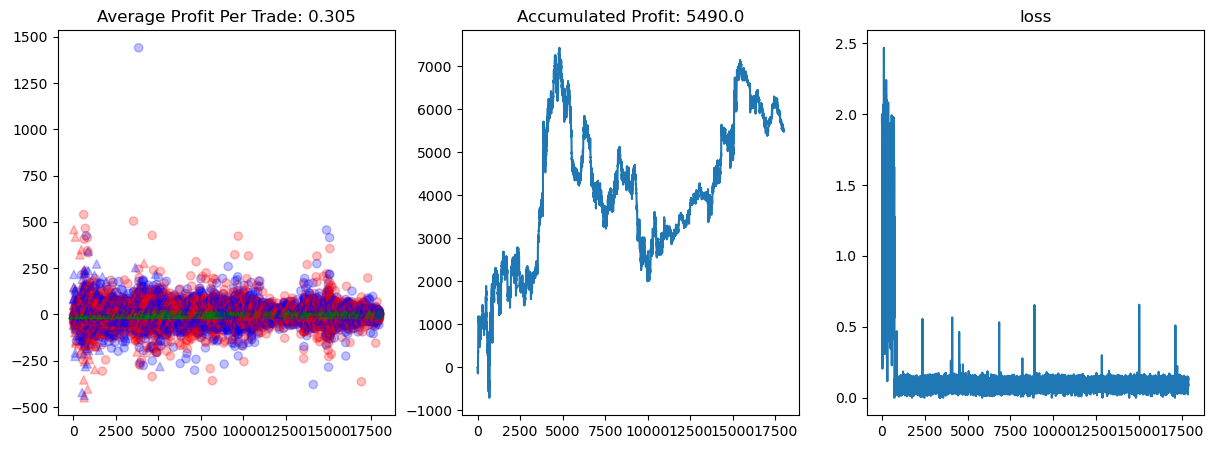

Epoch 1/1: 100%|██████████████████████████████████████████████| 18000/18000 [08:20<00:00, 35.98it/s]


In [112]:
# parameters
num_frames = 18000
memory_size = 15000
batch_size = 4
target_update = 16

# train

agent = DQNAgent(env, memory_size, batch_size, target_update,atom_size=4,n_step=4, lr = 0.00025)

num_epochs = 1  # Set the number of epochs
model_dir = "models"  # Set the directory to save the models

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

agent.train(num_frames, num_epochs, model_dir,plotting_interval=18000)

/tmp/ipykernel_28/774367307.py:576: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2).unsqueeze(1).to(device)


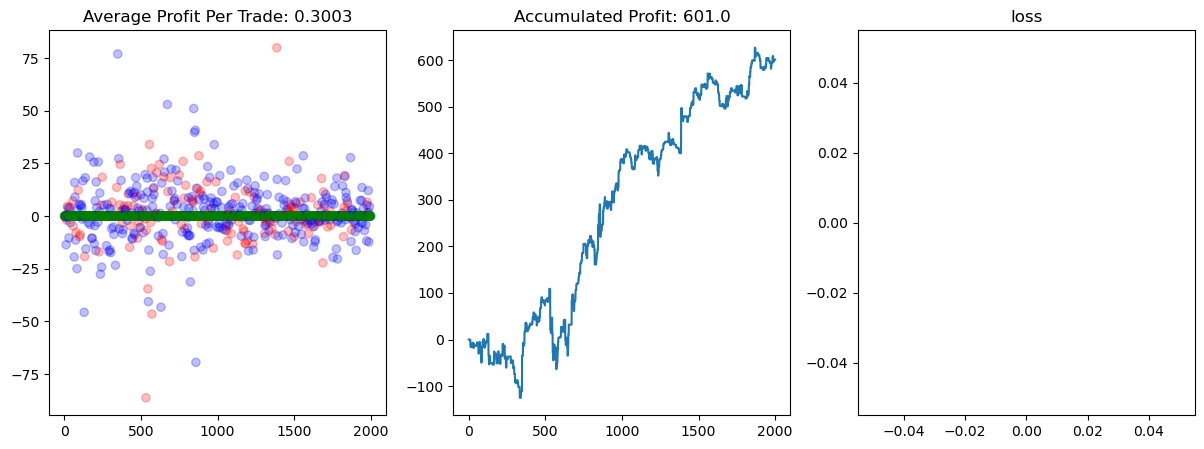

In [118]:
agent.test( plotting_interval= 2000,start_frame=18000-1)